In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from kan import KAN
import sympy as sp

In [8]:
def remove_non_numeric(datastr:str):
    datastr=str(datastr)
    return ''.join([c for c in datastr if c in '1234567890./'])
def divide_data(datastr:str):
    datastr=remove_non_numeric(datastr)
    if '/' in datastr:
        x, y = datastr.split('/')
        x=float(x)
        y=float(y)
        return x/y
    return float(datastr)
def parse_float(datastr:str):
    newstr=remove_non_numeric(datastr)
    return float(newstr)

In [9]:
data=pd.read_csv('../data/J_v6.tsv', sep='\t', names=['Jintra', 'deltaJ'])
data['Jinter']=20
data['Jintra'] = data['Jintra'].apply(lambda x: divide_data(x))
# normalize each column
data['Jintra'] = data['Jintra']/20
data['deltaJ'] = data['deltaJ']/20
data['Jinter'] = data['Jinter']/20

data['deltaJ/intra'] = data['deltaJ']/data['Jintra']
data['deltaJ*intra'] = data['deltaJ']*data['Jintra']
data['intra/deltaJ'] = data['Jintra']/data['deltaJ']
freqs=pd.read_csv('../data/Freqs_v6.tsv', sep=' ', names=['f1', 'f2', 'f3',"f1_analytical", "f2_analytical", "f3_analytical","diff1", "diff2", "diff3"])
for column in freqs.columns:
    freqs[column] = freqs[column].apply(lambda x: parse_float(x))
freqs=freqs.astype(float)

In [11]:
#indexselect=data.index[data['Jintra'] > 4.0/20].tolist()
#data=data.loc[indexselect]
#freqs=freqs.loc[indexselect]

In [12]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# labels
ax.set_xlabel('Jintra')
ax.set_ylabel('deltaJ')
ax.set_zlabel('Frequencies')
ax.scatter(data['Jintra'], data['deltaJ'], freqs.max(axis=1))
ax.scatter(data['Jintra'], data['deltaJ'], freqs.min(axis=1), c='r')
ax.scatter(data['Jintra'], data['deltaJ'], freqs.median(axis=1), c='g')

In [7]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[5,3,3,1], grid=5, k=5, seed=0)
dataset={}
dataset['train_input'] = torch.tensor(data[['Jintra', 'deltaJ', "deltaJ/intra", "deltaJ*intra", 'intra/deltaJ']].values, dtype=torch.float32)
dataset['train_label'] = torch.tensor(freqs[['f2']].values, dtype=torch.float32)/20
dataset['test_input'] =dataset['train_input']
dataset['test_label'] = dataset['train_label']

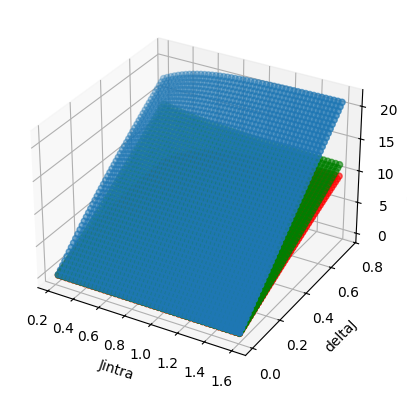

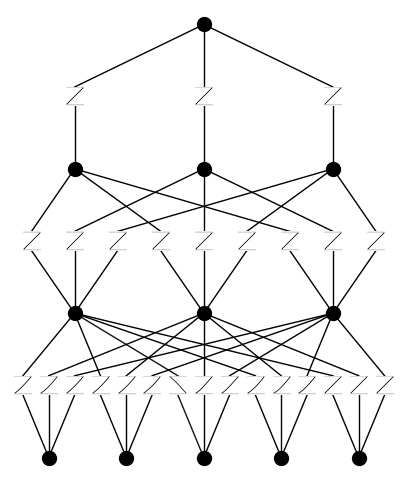

In [8]:
%matplotlib inline
model(dataset['train_input'])
model.plot(beta=100)

In [9]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

train loss: 1.41e-01 | test loss: 1.41e-01 | reg: 1.56e+01 : 100%|██| 20/20 [00:20<00:00,  1.05s/it]


{'train_loss': [array(0.113065, dtype=float32),
  array(0.12620479, dtype=float32),
  array(0.13222925, dtype=float32),
  array(0.14102641, dtype=float32),
  array(0.14044693, dtype=float32),
  array(0.14054479, dtype=float32),
  array(0.14128844, dtype=float32),
  array(0.14153068, dtype=float32),
  array(0.14061171, dtype=float32),
  array(0.14097267, dtype=float32),
  array(0.14119284, dtype=float32),
  array(0.14125735, dtype=float32),
  array(0.14130296, dtype=float32),
  array(0.14102963, dtype=float32),
  array(0.14104334, dtype=float32),
  array(0.14134322, dtype=float32),
  array(0.14138302, dtype=float32),
  array(0.14131169, dtype=float32),
  array(0.14128561, dtype=float32),
  array(0.1412801, dtype=float32)],
 'test_loss': [array(0.113065, dtype=float32),
  array(0.12620477, dtype=float32),
  array(0.13222925, dtype=float32),
  array(0.1410264, dtype=float32),
  array(0.14044695, dtype=float32),
  array(0.14054479, dtype=float32),
  array(0.14128844, dtype=float32),
  arra

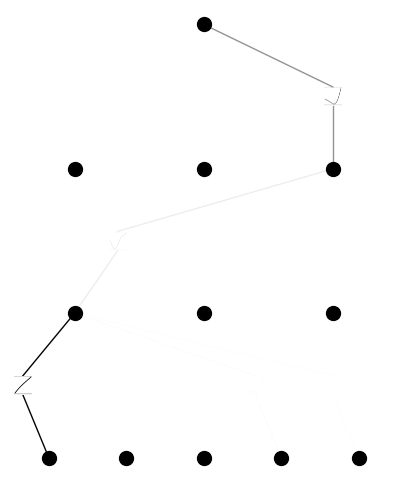

In [10]:
model.prune()
model.plot(mask=True)

In [11]:
model.train(dataset, opt="LBFGS", steps=50)

train loss: 2.07e-03 | test loss: 2.07e-03 | reg: 5.43e+00 : 100%|██| 50/50 [00:47<00:00,  1.05it/s]


{'train_loss': [array(0.01795587, dtype=float32),
  array(0.01194611, dtype=float32),
  array(0.00900305, dtype=float32),
  array(0.00697526, dtype=float32),
  array(0.00581838, dtype=float32),
  array(0.00571959, dtype=float32),
  array(0.00491545, dtype=float32),
  array(0.00468252, dtype=float32),
  array(0.00451672, dtype=float32),
  array(0.00435829, dtype=float32),
  array(0.00436994, dtype=float32),
  array(0.00401536, dtype=float32),
  array(0.00381856, dtype=float32),
  array(0.00358496, dtype=float32),
  array(0.00337113, dtype=float32),
  array(0.0036553, dtype=float32),
  array(0.00350373, dtype=float32),
  array(0.00344568, dtype=float32),
  array(0.00333486, dtype=float32),
  array(0.0032798, dtype=float32),
  array(0.01100803, dtype=float32),
  array(0.00427635, dtype=float32),
  array(0.00373445, dtype=float32),
  array(0.00327512, dtype=float32),
  array(0.00316436, dtype=float32),
  array(0.00669998, dtype=float32),
  array(0.00358072, dtype=float32),
  array(0.003045

In [12]:
lib = ['x','x^2','exp','sqrt']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with exp, r2=0.9970040917396545
fixing (0,0,1) with sqrt, r2=0.0
fixing (0,0,2) with sqrt, r2=0.0
fixing (0,1,0) with x^2, r2=0.9995675683021545
fixing (0,1,1) with sqrt, r2=0.0
fixing (0,1,2) with sqrt, r2=0.0
fixing (0,2,0) with exp, r2=0.9993162751197815
fixing (0,2,1) with sqrt, r2=0.0
fixing (0,2,2) with sqrt, r2=0.0
fixing (0,3,0) with exp, r2=0.9990741014480591
fixing (0,3,1) with sqrt, r2=0.0
fixing (0,3,2) with sqrt, r2=0.0
fixing (0,4,0) with exp, r2=0.9999711513519287
fixing (0,4,1) with sqrt, r2=0.0
fixing (0,4,2) with sqrt, r2=0.0
fixing (1,0,0) with sqrt, r2=0.0
fixing (1,0,1) with sqrt, r2=0.0
fixing (1,0,2) with x^2, r2=0.9992846250534058
fixing (1,1,0) with sqrt, r2=0.0
fixing (1,1,1) with sqrt, r2=0.0
fixing (1,1,2) with sqrt, r2=0.0
fixing (1,2,0) with sqrt, r2=0.0
fixing (1,2,1) with sqrt, r2=0.0
fixing (1,2,2) with sqrt, r2=0.0
fixing (2,0,0) with sqrt, r2=0.0
fixing (2,1,0) with sqrt, r2=0.0
fixing (2,2,0) with x^2, r2=0.9953822493553162


description:   0%|                                                           | 0/50 [00:03<?, ?it/s]


RuntimeError: false INTERNAL ASSERT FAILED at "..\\aten\\src\\ATen\\native\\BatchLinearAlgebra.cpp":1538, please report a bug to PyTorch. torch.linalg.lstsq: (Batch element 1): Argument 4 has illegal value. Most certainly there is a bug in the implementation calling the backend library.

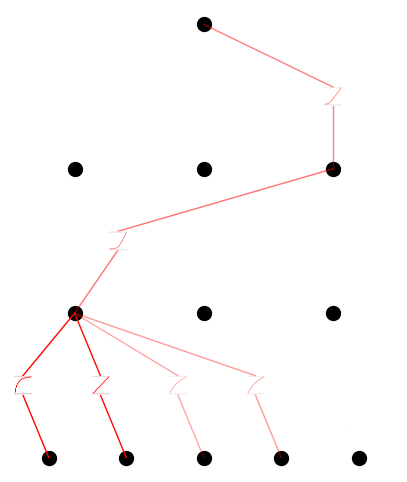

In [13]:
#model.train(dataset, opt="LBFGS", steps=50)
model.prune()
model.plot(mask=True)
model.train(dataset, opt="LBFGS", steps=50)

In [ ]:
model.symbolic_formula()[0][0]

2.77*(-0.4 - 1/(0.07*(0.84 - x_1)**2 + 2.17*(1 - 0.74*x_2)**3 + 1.39 - 1.65/(-3.3*x_4 - 1.55) - 5.23/(-2.08*x_3 - 3.21)))**2 - 0.85

In [ ]:
model.symbolic_formula()

([2.77*(-0.4 - 1/(0.07*(0.84 - x_1)**2 + 2.17*(1 - 0.74*x_2)**3 + 1.39 - 1.65/(-3.3*x_4 - 1.55) - 5.23/(-2.08*x_3 - 3.21)))**2 - 0.85],
 [x_1, x_2, x_3, x_4])

In [ ]:
sympy_expr=sp.sympify(model.symbolic_formula()[0][0])
simplified_expr = sp.simplify(sympy_expr)

In [ ]:
simplified_expr.expand()

-0.407 + 0.101/(0.000181*x_1**4 - 0.000607*x_1**3 - 0.00453*x_1**2*x_2**3 + 0.0183*x_1**2*x_2**2 - 0.0247*x_1**2*x_2 + 0.0191*x_1**2 + 0.00848*x_1**2/(3.3*x_4 + 1.55) + 0.0269*x_1**2/(2.08*x_3 + 3.21) + 0.00761*x_1*x_2**3 - 0.0308*x_1*x_2**2 + 0.0416*x_1*x_2 - 0.0312*x_1 - 0.0143*x_1/(3.3*x_4 + 1.55) - 0.0452*x_1/(2.08*x_3 + 3.21) + 0.0283*x_2**6 - 0.23*x_2**5 + 0.775*x_2**4 - 1.49*x_2**3 - 0.106*x_2**3/(3.3*x_4 + 1.55) - 0.337*x_2**3/(2.08*x_3 + 3.21) + 1.79*x_2**2 + 0.43*x_2**2/(3.3*x_4 + 1.55) + 1.36*x_2**2/(2.08*x_3 + 3.21) - 1.27*x_2 - 0.581*x_2/(3.3*x_4 + 1.55) - 1.84*x_2/(2.08*x_3 + 3.21) + 0.476 + 0.631/(6.86*x_3*x_4 + 3.22*x_3 + 10.6*x_4 + 4.98) + 0.00914/(x_4**2 + 0.939*x_4 + 0.221) + 0.097/(0.42*x_3**2 + 1.3*x_3 + 1) + 0.435/(3.3*x_4 + 1.55) + 1.38/(2.08*x_3 + 3.21)) + 2.22/(0.07*x_1**2 - 0.12*x_1 - 0.88*x_2**3 + 3.57*x_2**2 - 4.81*x_2 + 3.61 + 1.65/(3.3*x_4 + 1.55) + 5.23/(2.08*x_3 + 3.21))